# FYP-DL: Random Forest - Countering Imbalance via Class Weights

Didn't get great results with Logistic Regression. FN and FP rates improved when considered on the basis of an individual class, but overall ROC remained the same, and FPs increased substantially.

Maybe random forest classifiers will do better?

# Imports

In [ ]:
# For loading data from Drive
from google.colab import drive, files

# Standard Imports
import pandas as  pd
import os 
import numpy as np

from matplotlib import pyplot as plt 
%matplotlib inline 
from matplotlib import style 
style.use('ggplot')

# Sklearn - Model Selection
from sklearn.model_selection import RandomizedSearchCV, train_test_split 

# Sklearn - Model Evaluation 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, \
plot_confusion_matrix, plot_roc_curve

# Sklearn - Random Forest
from sklearn.ensemble import RandomForestClassifier

# Sklearn - Class Weights
from sklearn.utils.class_weight import compute_class_weight

# Random Number Seeding
np.random.seed(0)

In [ ]:
def get_classification_result(estimator, X, y_true, classifier_name=None,
                              normalize_conf_mat='all'):
    """Custom function to display classification results"""
    # Predictions will be used several times
    y_pred = estimator.predict(X) 

    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves'],))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    if (normalize_conf_mat=='rows'):
      normalize='true'
    elif (normalize_conf_mat=='cols'):
        normalize='pred'
    else:
      normalize=normalize_conf_mat

    # Use built-in function to get confusion matrix for this estimator
    conf_mat_display = plot_confusion_matrix(estimator=estimator, 
                                             X=X, 
                                             y_true=y_true, 
                                             labels=[0, 1],
                                             normalize=normalize, 
                                             display_labels=['Regular Consumers', 'Thieves'], 
                                             cmap=plt.cm.Blues)
    
    # Add a title (with optional classifier name)
    conf_mat_display.ax_.set_title("Confusion Matrix - {}".format(
        classifier_name if classifier_name is not None 
        else 'Test Classifier' ))
    
    # This will render the confusion matrix as an image
    print(conf_mat_display.confusion_matrix);
    plt.grid(False)       # Remove extra lines from confusion matrix

    roc_curve_display = plot_roc_curve(estimator, X, y_true)
    roc_curve_display.ax_.set_title('ROC Curve' +
                                    ('' if classifier_name is None else ' - {}'.format(classifier_name)), 
                                    fontsize=18);

# Importing Modules

In [ ]:
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/pipelines.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/plot_utils.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/wdnn_transformers.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/build_WDNN.py"

# Loading Data

In [ ]:
# Mount Google Drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# Defining filepaths
ROOT_DIR = "/content/drive/My Drive"
FYP_DIR = "EE 16-17 FYP DL Energy Theft Detection"
DATA_DIR = "Data/full-processing-data"
FILE_NAME = "outliersRemoved.csv"

# Create filepath
FILE_PATH = os.path.join(ROOT_DIR, FYP_DIR, DATA_DIR, FILE_NAME)

In [ ]:
# Print the filepath for checking
print(FILE_PATH)

/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv


In [ ]:
df = pd.read_csv(FILE_PATH)
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


In [ ]:
# Create independent and Dependent features
columns = df.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["FLAG"]]
# store the variable we are predicting
target = "FLAG"
# Define a random state
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
print(X.shape)
print(Y.shape)

(42372, 1035)
(42372,)


**Exploratory data analysis**

In [ ]:
Thieves = df[df['FLAG']==1]

Regular_consumers = df[df['FLAG']==0]

In [ ]:
print(Thieves.shape,Regular_consumers.shape)

(3615, 1036) (38757, 1036)


# Train-Test Split

In [ ]:
features, labels = df.iloc[:, 2:], df.iloc[:, 1]

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=labels.values)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  random_state=0, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val.values)

In [ ]:
print(X_train.shape, y_train.shape)

(27117, 1034) (27117,)


# Feature Scaling

In [ ]:
# Import the pipeline functions from the pipeline modules
from pipelines import get_pipeline_1D, get_pipeline_2D

# Creating pipeline objects
pipeline_1D = get_pipeline_1D(scaling_strategy='Standard')

# Fit and then transform the pipelines to the training data first 
X_train_val_1D = pipeline_1D.fit_transform(X_train_val)
X_train_1D = pipeline_1D.fit_transform(X_train)
X_val_1D = pipeline_1D.fit_transform(X_val)
X_test_1D = pipeline_1D.fit_transform(X_test)

# Class Weights 01 - `sklearn` API

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train_val
)

# Create a dictionary that can be passed to an `sklearn` estimator
cw_sklearn = dict(zip([0, 1], class_weights))

# Output this: does it make sense?
cw_sklearn

{0: 0.5466376390904693, 1: 5.860477178423237}

# Oversampling minority class (Thieves)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
os = RandomOverSampler(ratio=0.8)

In [ ]:
X.drop('CONS_NO', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_train_val_1D, y_train_val = os.fit_sample(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(X_train_val_1D.shape, y_train_val.shape)

(69762, 1034) (69762,)


In [ ]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_train_val)))

Original dataset shape Counter({0: 38757, 1: 3615})
Resampled dataset shape Counter({0: 38757, 1: 31005})


# Random Forest Classifier - Zheng

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                random_state=0, verbose=2, 
                                class_weight=cw_sklearn)

In [ ]:
rf_clf.fit(X_train_val_1D, y_train_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  6.6min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5466376390904693,
                                     1: 5.860477178423237},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=2,
                       warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      0.95      0.93      7752
         Thieves       0.05      0.03      0.03       723

        accuracy                           0.87      8475
       macro avg       0.48      0.49      0.48      8475
    weighted avg       0.84      0.87      0.85      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.86772861 0.04696165]
 [0.08306785 0.00224189]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


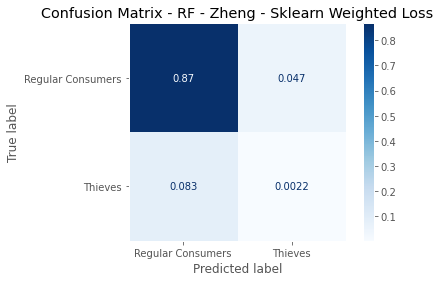

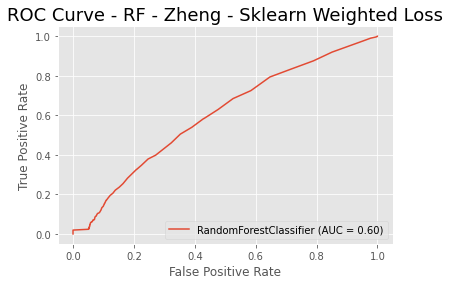

In [ ]:
get_classification_result(estimator=rf_clf, X=X_test_1D, y_true=y_test, 
                          classifier_name="RF - Zheng - Sklearn Weighted Loss")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      0.95      0.93      7752
         Thieves       0.05      0.03      0.03       723

        accuracy                           0.87      8475
       macro avg       0.48      0.49      0.48      8475
    weighted avg       0.84      0.87      0.85      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.94865841 0.05134159]
 [0.97372061 0.02627939]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


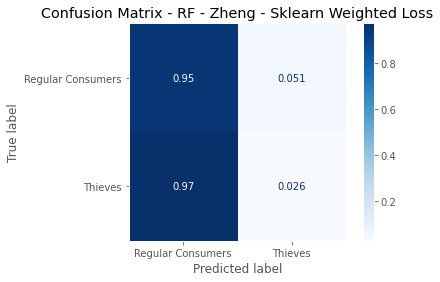

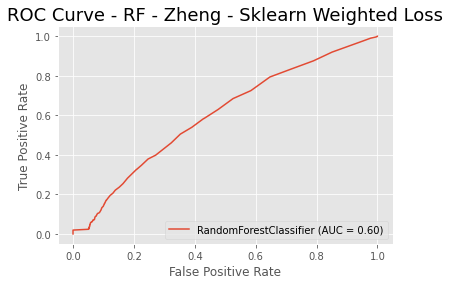

In [ ]:
get_classification_result(estimator=rf_clf, X=X_test_1D, y_true=y_test, 
                          classifier_name="RF - Zheng - Sklearn Weighted Loss",
                          normalize_conf_mat="rows")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      0.95      0.93      7752
         Thieves       0.05      0.03      0.03       723

        accuracy                           0.87      8475
       macro avg       0.48      0.49      0.48      8475
    weighted avg       0.84      0.87      0.85      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.91263341 0.95443645]
 [0.08736659 0.04556355]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished


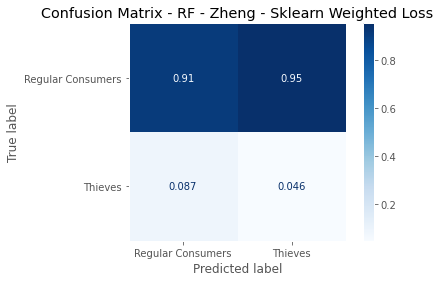

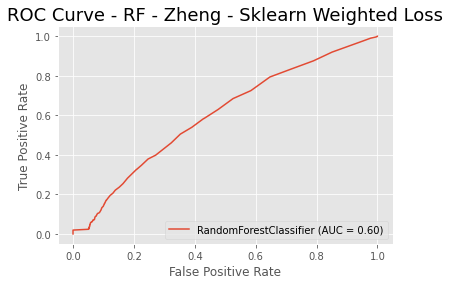

In [ ]:
get_classification_result(estimator=rf_clf, X=X_test_1D, y_true=y_test, 
                          classifier_name="RF - Zheng - Sklearn Weighted Loss",
                          normalize_conf_mat="cols")

#  Classifier without Weights

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                    random_state=0, verbose=2)
rf_clf.fit(X_train_val_1D, y_train_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=2,
                       warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.65      0.02      0.05       723

        accuracy                           0.92      8475
       macro avg       0.79      0.51      0.50      8475
    weighted avg       0.89      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.91362832 0.00106195]
 [0.08330383 0.0020059 ]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


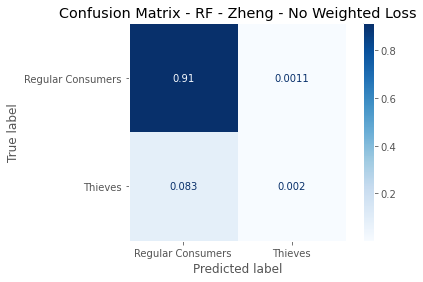

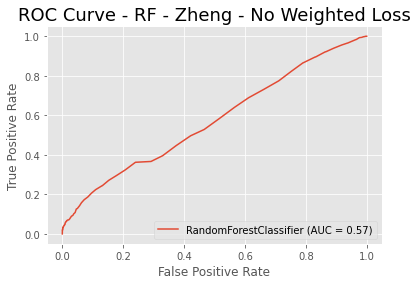

In [ ]:
get_classification_result(rf_clf, X_test_1D, y_test, "RF - Zheng - No Weighted Loss", 
                          normalize_conf_mat='all')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.65      0.02      0.05       723

        accuracy                           0.92      8475
       macro avg       0.79      0.51      0.50      8475
    weighted avg       0.89      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.99883901 0.00116099]
 [0.97648686 0.02351314]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


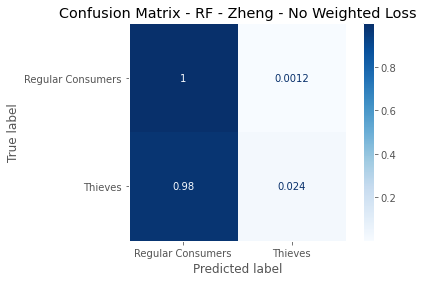

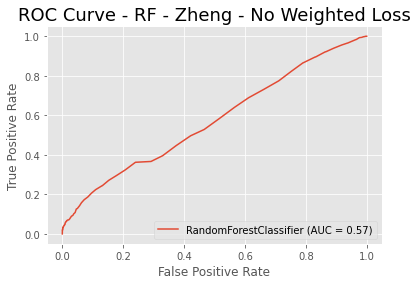

In [ ]:
get_classification_result(rf_clf, X_test_1D, y_test, "RF - Zheng - No Weighted Loss", 
                          normalize_conf_mat='rows')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.65      0.02      0.05       723

        accuracy                           0.92      8475
       macro avg       0.79      0.51      0.50      8475
    weighted avg       0.89      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.91643982 0.34615385]
 [0.08356018 0.65384615]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


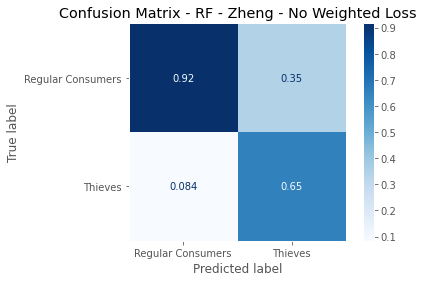

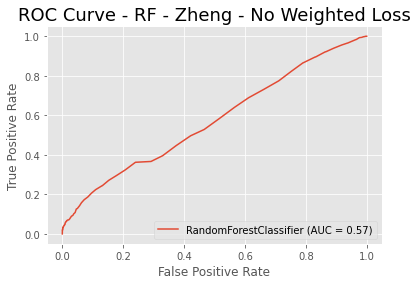

In [ ]:
get_classification_result(rf_clf, X_test_1D, y_test, "RF - Zheng - No Weighted Loss", 
                          normalize_conf_mat='cols')

# MinMax Scaling

In [ ]:
# Creating pipeline objects
pipeline_1D = get_pipeline_1D(scaling_strategy='MinMax')

# Fit and then transform the pipelines to the training data first 
X_train_val_1D = pipeline_1D.fit_transform(X_train_val)
X_train_1D = pipeline_1D.fit_transform(X_train)
X_val_1D = pipeline_1D.fit_transform(X_val)
X_test_1D = pipeline_1D.fit_transform(X_test)

# RF Classifier 01 - Weights

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                random_state=0, verbose=2, 
                                class_weight=cw_sklearn)
rf_clf.fit(X_train_val_1D, y_train_val)

building tree 1 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: ignored

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.82      0.05      0.09       723

        accuracy                           0.92      8475
       macro avg       0.87      0.52      0.53      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.91374631 0.00094395]
 [0.08106195 0.00424779]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


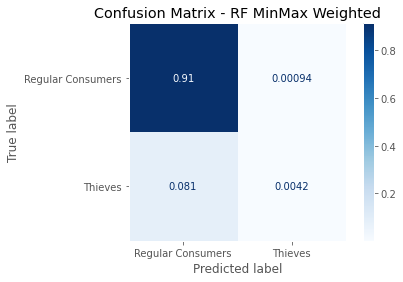

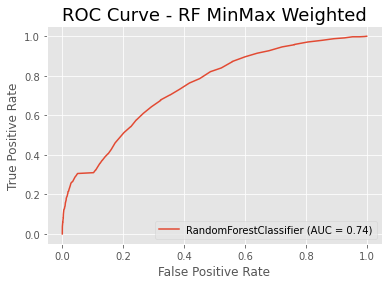

In [ ]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="all")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.82      0.05      0.09       723

        accuracy                           0.92      8475
       macro avg       0.87      0.52      0.53      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.99896801 0.00103199]
 [0.95020747 0.04979253]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


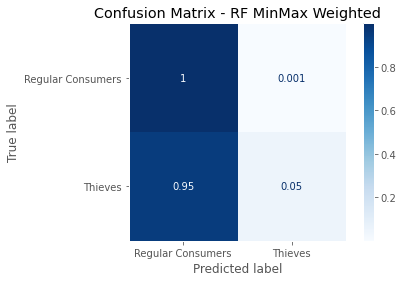

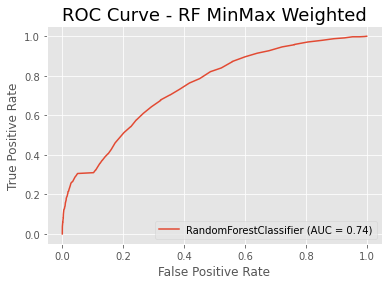

In [ ]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="rows")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.82      0.05      0.09       723

        accuracy                           0.92      8475
       macro avg       0.87      0.52      0.53      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.918515   0.18181818]
 [0.081485   0.81818182]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


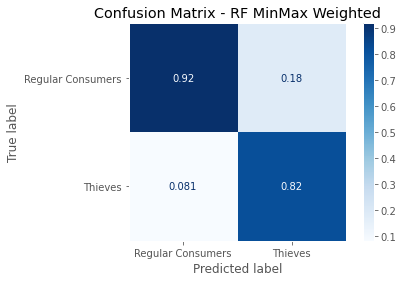

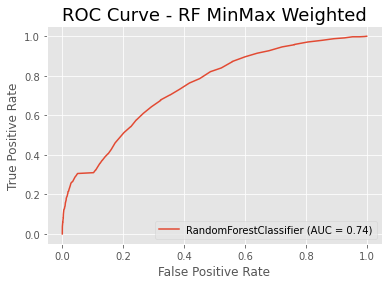

In [ ]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="cols")

# Without Weights

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                random_state=0, verbose=2)
rf_clf.fit(X_train_val_1D, y_train_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.84      0.04      0.08       723

        accuracy                           0.92      8475
       macro avg       0.88      0.52      0.52      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[9.13982301e-01 7.07964602e-04]
 [8.16519174e-02 3.65781711e-03]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished


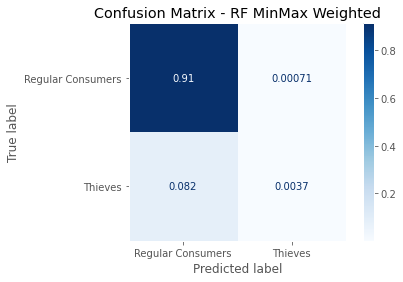

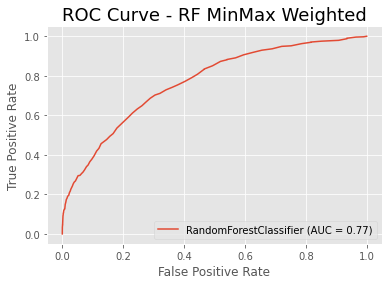

In [ ]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="all")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.84      0.04      0.08       723

        accuracy                           0.92      8475
       macro avg       0.88      0.52      0.52      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[9.99226006e-01 7.73993808e-04]
 [9.57123098e-01 4.28769018e-02]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


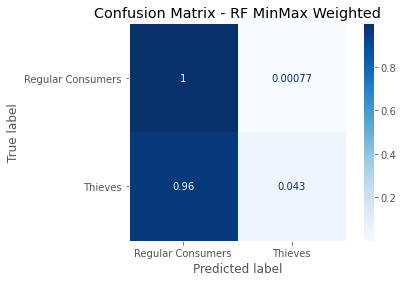

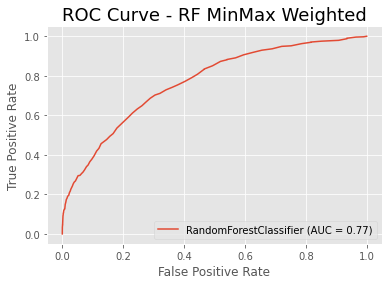

In [ ]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="rows")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.84      0.04      0.08       723

        accuracy                           0.92      8475
       macro avg       0.88      0.52      0.52      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.91799005 0.16216216]
 [0.08200995 0.83783784]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished


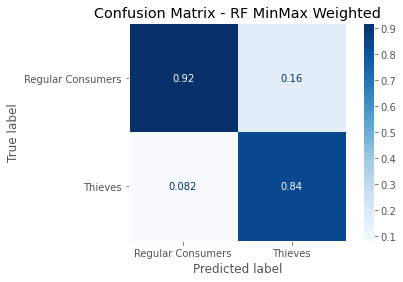

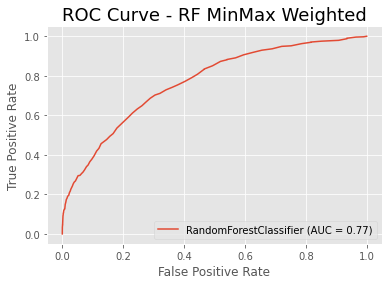

In [ ]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="cols")